### Programming Assignment 3.1: Support objects

- work with support vector machine (SVM)
- find the most important sample objects

In [8]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold

In [9]:
df = pd.read_csv('svm.csv', header = None)

In [10]:
df.head()
y = df[0]
X = df.drop(columns=0)

#X.to_numpy()[1, :]

In [15]:
model = SVC(C=100000, random_state=241, kernel='linear')
model.fit(X, y)

SVC(C=100000, kernel='linear', random_state=241)

In [14]:
# these are support objects:
model.support_

array([3, 4, 9], dtype=int32)

### Programming Assignment 3.2: Text analysis

- find optimal parameters for support vector machine
- work with text data

In [3]:
newsgroups = datasets.fetch_20newsgroups(
                    subset='all', 
                    categories=['alt.atheism', 'sci.space']
             )

X_train = newsgroups.data
y_train = newsgroups.target

Вычислите TF-IDF-признаки для всех текстов. Обратите внимание, что в этом задании мы предлагаем вам вычислить TF-IDF по всем данным. При таком подходе получается, что признаки на обучающем множестве используют информацию из тестовой выборки — но такая ситуация вполне законна, поскольку мы не используем значения целевой переменной из теста. На практике нередко встречаются ситуации, когда признаки объектов тестовой выборки известны на момент обучения, и поэтому можно ими пользоваться при обучении алгоритма.

1. Как я понимаю, каждое слово в тексте заменится на определенное уникальное число для удобства работы. Делается это с помощью TfidfVectorizer.fit_transform(x)

In [4]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)

2. Данный пункт - оптимизация параметра C в классификаторе SVC с помощью функции GridSearchCV(). Для "грида" нужно передать значения С, среди которых будет искаться самое эффективное и генератор разделений KFold. После, 'грид' нужно обучить указав векторизированное X и Y. 

In [5]:
grid = {'C': np.power(10.0, np.arange(-5, 6))}
cv = KFold(n_splits=5, shuffle=True, random_state=241)
clf = SVC(kernel='linear', random_state=241)
gs = GridSearchCV(clf, grid, scoring='accuracy', cv=cv)
gs.fit(X_train_vect, y_train)

gs.best_estimator_, gs.best_score_, gs.best_params_

(SVC(kernel='linear', random_state=241), 0.9932804406678872, {'C': 1.0})

3. После этого нам необходимо сделать тоже самое, но уже без 'грида'. Передаем SVC оптимальное значение С: SVC(kernel='linear', random_state=241, С=1. Обучаем его на той же выборке что и грид через fit()

In [6]:
model = SVC(C=1, kernel='linear', random_state=241)
model.fit(X_train_vect, y_train)

SVC(C=1, kernel='linear', random_state=241)

4. Нужно получить наибольшие 10 весов из обученного классификатора (SVC), узнать их индексы. Потом по этим индексам узнать с помощью vectorizer.get_feature_names() каким словам принадлежат эти индексы. 

In [7]:
# coef_ - разряженная матрица, к тому же неотсортированная по убыванию или возрастанию.
# Разряженную матрицу можно привести к обычной с помощью todense().
coefs = model.coef_.todense().A1
coefs = abs(coefs)
# После этого берем модуль от матрицы (то есть всех значений). 
# Т.к. как я понимаю, веса одного класса будут отрицатлеьными, а другого класса – положительными

# Теперь нужно упорядочить массив по возрастанию (или убыванию). 
# При этом упорядочить надо так, чтобы индексы не поменялись.
# Можно использовать np.argsort(). Функция сортирует индексы элементов по возрастанию величины элементов.
coefs = np.argsort(coefs)[-10:]

# C помощью vectorizer.get_feature_names() узнаем каким словам принадлежат эти индексы.
words = np.take(vectorizer.get_feature_names(), coefs)

# Сортируем слова в лексикографическом порядке. 
sorted(words)

['atheism',
 'atheists',
 'bible',
 'god',
 'keith',
 'moon',
 'religion',
 'sci',
 'sky',
 'space']

## Но что означают абсолютные значения коэф-ов? что значит тот факт, что у слова atheism –  кэф самый большой?

#### Sandbox

In [172]:
b = np.matrix([[4, 2],[3,5]])
np.argsort(b.A1)[0:3]

array([1, 2, 0])

### Programming Assignment 3.3: Logistic regression

- work with logistic regression
- implement gradient descent to customize it
- use regularization

In [676]:
from math import exp, log
from numpy.linalg import norm
from sklearn.metrics import roc_auc_score

df = pd.read_csv('data-logistic.csv', header=None, names=['y', 'x1', 'x2'])

In [677]:
def distance(w1, w2):
    return np.sqrt(np.square(w1[0] - w2[0]) + np.square(w1[1] - w2[1]))

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

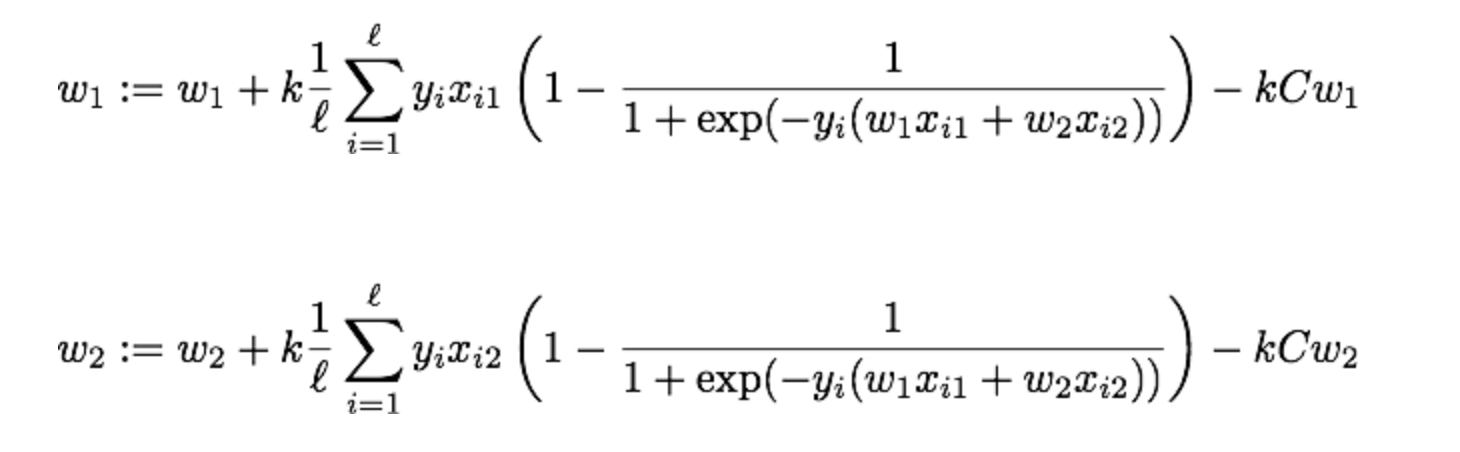

In [678]:
def calc_sums(w1, w2):
    summa1 = 0
    summa2 = 0
    for i in range(0, 205):
        common = (1 - 1/(1 + exp(-df['y'][i] * (w1 * df['x1'][i] + w2 * df['x2'][i]))))
        
        summa1 += df['x1'][i] * df['y'][i] * common 
        summa2 += df['x2'][i] * df['y'][i] * common
    
    return summa1, summa2

def log_reg(C, k, max_iter):
    w1, w2 = 0, 0

    for n in range(0, max_iter):
        s1, s2 = calc_sums(w1, w2)

        new_w1 = w1 + k * s1/l - (k * C * w1)
        new_w2 = w2 + k * s2/l - (k * C * w2)

        dist = distance((w1, w2), (new_w1, new_w2))

        if dist < 0.0001:
            print(f'w1: {w1} w2: {w2} \nn: {n}, dist: {dist}')
            break 

        w1 = new_w1
        w2 = new_w2

    predictions = []
    for i in range(0, 205):
        t1 = w1 * df['x1'][i] + w2 * df['x2'][i]
        s = sigmoid(t1)
        predictions.append(s)
        
    print(f'{roc_auc_score(df["y"], predictions)} \n')

log_reg(0, 0.1, 10_000)
log_reg(10, 0.1, 10_000)

w1: 0.25704671613527813 w2: 0.11977148255430584 
n: 512, dist: 9.997083013177199e-05
0.9325714285714286 

w1: 0.02793057899019212 w2: 0.02436848059077782 
n: 29, dist: 9.43301639992076e-05
0.9362857142857142 



In [687]:
import matplotlib.pyplot as plt

def log_reg_new(df, C, k, max_iter):
    y = df.values[:, :1].T
    X = df.values[:, 1:]
    
    w1, w2 = 0, 0

    for n in range(0, max_iter):
        common = (1 - 1/(1 + np.exp(-y * (w1 * X[:,0] + w2 * X[:,1]))))

        new_w1 = w1 + k * np.mean(X[:,0] * y * common) - (k * C * w1)
        new_w2 = w2 + k * np.mean(X[:,1] * y * common) - (k * C * w2)

        dist = distance((w1, w2), (new_w1, new_w2))

        if dist < 0.0001:
            print(f'w1: {w1} w2: {w2} \nn: {n}, dist: {dist}')
            break 

        w1 = new_w1
        w2 = new_w2

    predictions = sigmoid(w1 * X[:,0] + w2 * X[:,1])
    
    print(f'{roc_auc_score(y.T, predictions)} \n')
    
log_reg_new(df, 0, 0.1, 10_000)
log_reg_new(df, 10, 0.1, 10_000)

w1: 0.2881081945740146 w2: 0.0917091004787856 
n: 1011, dist: 9.858894641103832e-14
0.9267619047619047 

w1: 0.028559431523877403 w2: 0.02478087899703931 
n: 21, dist: 4.49514561349585e-14
0.9362857142857142 



### Programming Assignment 3.4: Classification quality metrics

**1 Calculate confusion matrix (TP, FP, FN, TN)**

In [596]:
from sklearn.metrics import confusion_matrix

df = pd.read_csv('classification.csv')
df.value_counts()

true  pred
0     0       64
1     0       59
      1       43
0     1       34
dtype: int64

In [597]:
confusion_matrix(df.true, df.pred)

array([[64, 34],
       [59, 43]])

In [604]:
TP, FN, FP, TN = 0, 0, 0, 0

for index, row in df.iterrows():
    if row.true == 1:
        if row.pred == 1:
            TP+=1
        else:
            FN+=1
    if row.true == 0:
        if row.pred == 1:
            FP+=1
        else:
            TN+=1
        
TP, FP, FN, TN

(43, 34, 59, 64)

**2 Calculate**
- Accuracy (доля верно угаданных) — sklearn.metrics.accuracy_score
- Precision (точность) — sklearn.metrics.precision_score
- Recall (полнота) — sklearn.metrics.recall_score
- F-мера — sklearn.metrics.f1_score

In [612]:
from sklearn.metrics import accuracy_score
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy, accuracy_score(df.true, df.pred)

(0.535, 0.535)

In [613]:
from sklearn.metrics import precision_score
precision = TP / (TP + FP)
precision, precision_score(df.true, df.pred)

(0.5584415584415584, 0.5584415584415584)

In [614]:
from sklearn.metrics import recall_score
recall = TP / (TP + FN)
recall, recall_score(df.true, df.pred)

(0.4215686274509804, 0.4215686274509804)

In [615]:
from sklearn.metrics import f1_score
f = 2 * precision * recall / (precision + recall)
f, f1_score(df.true, df.pred)

(0.48044692737430167, 0.48044692737430167)

**3 AUC-ROC**

In [624]:
from sklearn.metrics import roc_auc_score

scores_df = pd.read_csv('scores.csv')
scores_df.head()

,true,score_logreg,score_svm,score_knn,score_tree
0,0,0.683832,0.145976,0.787063,0.500000
1,1,0.801966,0.239511,1.000000,0.833333
2,0,0.382315,-0.245701,0.000000,0.000000
3,1,0.506797,-0.137058,0.000000,0.105263
4,1,0.488781,-0.154148,0.000000,0.105263


Посчитайте площадь под ROC-кривой для каждого классификатора

In [630]:
print('score_logreg', roc_auc_score(scores_df.true, scores_df.score_logreg))
print('score_svm', roc_auc_score(scores_df.true, scores_df.score_svm))
print('score_knn', roc_auc_score(scores_df.true, scores_df.score_knn))
print('score_tree', roc_auc_score(scores_df.true, scores_df.score_tree))

score_logreg 0.719187675070028
score_svm 0.7086834733893557
score_knn 0.6351540616246498
score_tree 0.6919267707082833


Какой классификатор достигает наибольшей точности (Precision) при полноте (Recall) не менее 70% ? 

Можно все точки precision-recall-кривой с помощью функции sklearn.metrics.precision_recall_curve. Она возвращает три массива: precision, recall, thresholds. В них записаны точность и полнота при определенных порогах, указанных в массиве thresholds. Остается найти максимальной значение точности среди тех записей, для которых полнота не меньше, чем 0.7.

In [647]:
from sklearn.metrics import precision_recall_curve

prec, rec, threshhold = precision_recall_curve(scores_df.true, scores_df.score_logreg)

In [673]:
def calculate_best_precision_recall(prec, rec, threshhold):
    precision = 0
    recall = 0
    thresh = 0
    idx = 0

    for i, thr in enumerate(threshhold):
        if rec[i] >= 0.7 and prec[i] > precision:
            precision = prec[i]
            recall = rec[i]
            thresh = thr
            idx = i

    print(f'precision: {precision}, recall: {recall},\nthresh: {thresh}, f_score: {2 * precision * recall / (precision + recall)}')

In [674]:
for col in scores_df.columns[1:]:
    prec, rec, threshhold = precision_recall_curve(scores_df.true, scores_df[col])
    print(col)
    calculate_best_precision_recall(prec, rec, threshhold)
    print()


score_logreg
precision: 0.6302521008403361, recall: 0.7653061224489796,
thresh: 0.4885220002986035, f_score: 0.6912442396313363

score_svm
precision: 0.6228070175438597, recall: 0.7244897959183674,
thresh: -0.1235403305867105, f_score: 0.669811320754717

score_knn
precision: 0.6065573770491803, recall: 0.7551020408163265,
thresh: 0.3193344964912923, f_score: 0.6727272727272727

score_tree
precision: 0.6517857142857143, recall: 0.7448979591836735,
thresh: 0.4, f_score: 0.6952380952380953



In [732]:
X = np.matrix([[1, 2104, 5, 1, 45], [1, 1416, 3, 2, 40], [1, 1534, 3, 2, 30], [1, 852, 2, 1, 36]])
y = np.matrix([[460], [232], [315], [178]])
X_t = np.transpose(X)

theta = np.linalg.pinv(X_t * X) * X_t * y 

In [731]:
X[3] * theta

matrix([[178.]])